# Heat-exchanger data analysis

## Cristian Merli - UniTn id: 211384

### Software header (info)

### Useful links

https://code.visualstudio.com/docs/datascience/data-science-tutorial

In [11]:
__author__ = "Cristian Merli"
__copyright__ = "Copyright 2021, The Cogent Project"
__credits__ = ["Cristian Merli", "Ing. Maurizio Grigiante"]
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Cristian Merli"
__email__ = "cristian.merli@studenti.unitn.it"
__status__ = "Draft"

### Libraries import

In [12]:
import fileinput as fi                                                          # File management lib
import pandas as pd                                                             # Data-analysis panda lib
import numpy as np                                                              # Data-analysis numpy lib
import seaborn as sns                                                           # Seaborn plottin' lib
import matplotlib.pyplot as plt                                                 # Math plottin' lib

### Dataset vars

* Dataset file: original (.dat) file and formatted (.csv) file

In [13]:
dat_data_filepath = "../dataset/scambiatore26112021_5.dat"                      # Original dataset filepath (.dat)
csv_data_filepath = "../dataset/scambiatore26112021_5.csv"                      # Formatted dataset filepath (generate new .csv file)

* Modifications to perform while converting and formatting (.dat) file into (.csv) file

In [14]:
old_sep_chr = '\t'                                                              # Sep chr in (.dat) file
new_sep_chr = ';'                                                               # Sep chr in (.csv) file
comments_str = "% "                                                             # Delete comment-strings in (.dat) file when creatin' (.csv) file
other_op_old_lbl = "Altra operazione"                                           # Replace 'other oper' lbl

* Heat-exchanger operation labels

In [15]:
other_op_lbl = "Altra-operazione"                                               # Other oper lbl
cocurrent_flow_lbl = "Equicorrente"                                             # Cocurrent flow lbl
countercurrent_flow_lbl = "Controcorrente"                                      # Countercurrent flow lbl

* Dataset columns

In [16]:
time_col = "Time(s)"                                                            # Time col in dataset (time ellapsed vals [s])
f1_col = "F1(l/h)"                                                              # Volume flow rate 1 col in dataset (cold fluid volume flow rate vals [l/h])
f2_col = "F2(l/h)"                                                              # Volume flow rate 2 col in dataset (hot fluid volume flow rate vals [l/h])
t1_col = "T1(degC)"                                                             # Temp 1 col in dataset (cold-in fluid temp vals [°C])
t2_col = "T2(degC)"                                                             # Temp 2 col in dataset (hot-in fluid temp vals [°C])
t3_col = "T3(degC)"                                                             # Temp 3 col in dataset (cold-out fluid temp vals [°C])
t4_col = "T4(degC)"                                                             # Temp 4 col in dataset (hot-out fluid temp vals [°C])
config_col = "Configurazione"                                                   # Config col in dataset

### Dataset formatting, import and plot

* Convert and format dataset: open and manipulate data in (.dat) file, writing formatted data inside (.csv) file

In [17]:
with open(dat_data_filepath,'r') as src_fl:                                     # Open src file in read mode: (.dat) file
  with open(csv_data_filepath,'w') as dest_fl:                                  # Open dest file in write mode: (.csv) file
      next(src_fl)                                                              # Skip header line in src file
      for line in src_fl:                                                       # Read src file line-by-line
          line = line.replace(other_op_old_lbl, other_op_lbl)                   # Replace target string (other operation label)
          line = line.replace(old_sep_chr, new_sep_chr)                         # Replace data separator-chars
          line = line.replace(comments_str, '')                                 # Delete target string (comment string in src file)
          dest_fl.write(line)                                                   # Write each formatted data line inside dest file (.csv)

* Import dataset data from formatted (.csv) file, creating a 'DataFrame' variable

In [18]:
he_data = pd.read_csv(csv_data_filepath, sep=new_sep_chr, encoding='utf8')      # Import data in (.csv) dataset and create a new panda (lib) DataFrame variable: 'he_data'

* Plot data in DataFrame 'he_data' variable: temperatures and volume flow rates, taken during LabView data-acquisition on heat-exchanger

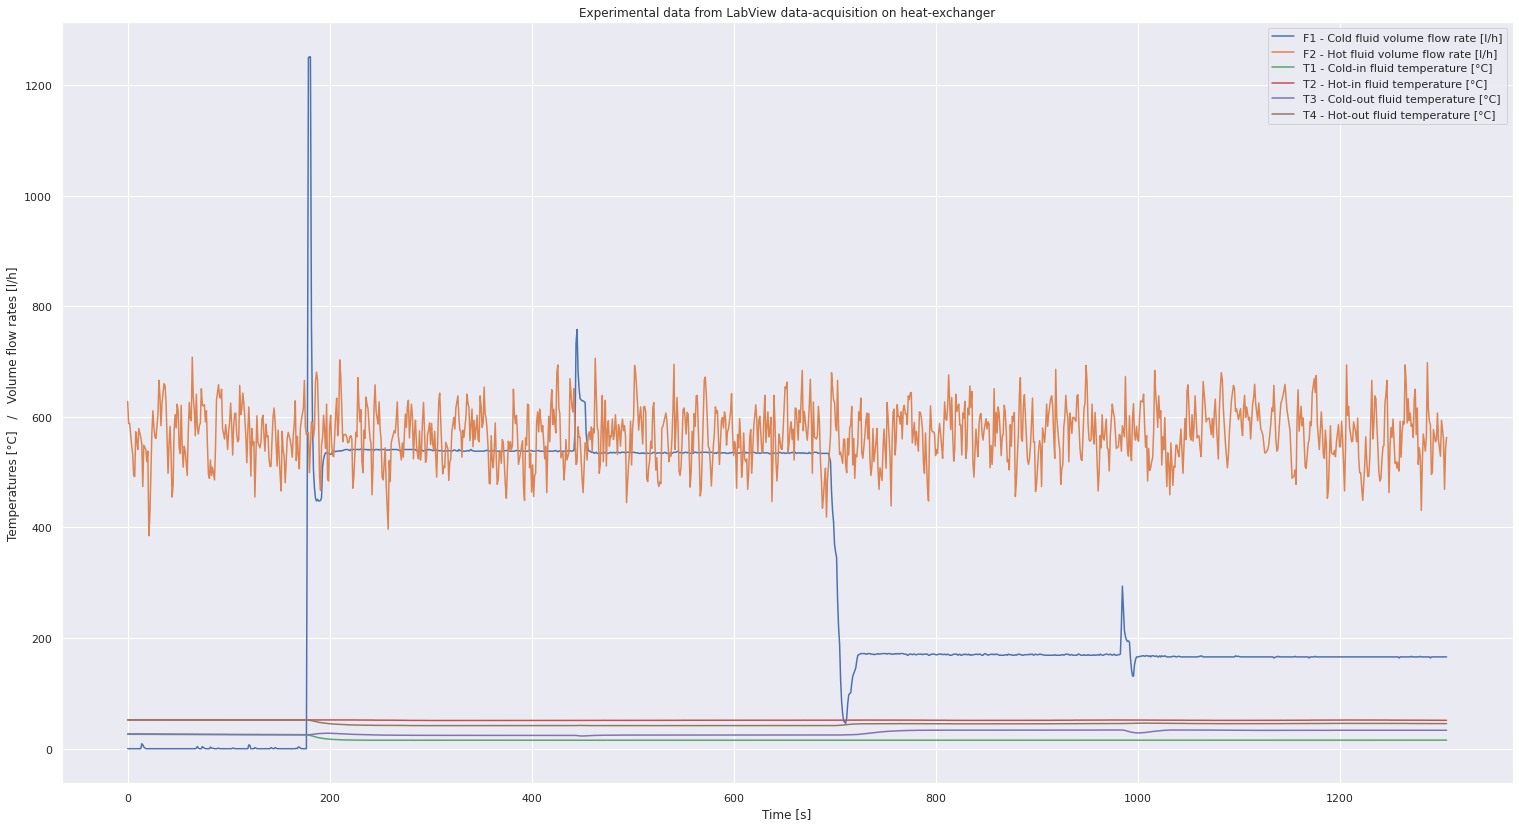

In [19]:
plt.title('Experimental data from LabView data-acquisition on heat-exchanger')                          # Plot title
plt.xlabel("Time [s]")                                                                                  # X-axis lbl
plt.ylabel("Temperatures [°C]   /   Volume flow rates [l/h]")                                           # Y-axis lbl
sns.set(rc={'figure.figsize':(26,14)})                                                                  # Plottin' size
sns.lineplot(x=time_col, y=f1_col, data=he_data, label='F1 - Cold fluid volume flow rate [l/h]')        # Cold fluid vol flow rate (F1)
sns.lineplot(x=time_col, y=f2_col, data=he_data, label='F2 - Hot fluid volume flow rate [l/h]')         # Hot fluid vol flow rate (F2)
sns.lineplot(x=time_col, y=t1_col, data=he_data, label='T1 - Cold-in fluid temperature [°C]')           # Cold-in fluid temp (T1)
sns.lineplot(x=time_col, y=t2_col, data=he_data, label='T2 - Hot-in fluid temperature [°C]')            # Hot-in fluid temp (T2)
sns.lineplot(x=time_col, y=t3_col, data=he_data, label='T3 - Cold-out fluid temperature [°C]')          # Cold-out fluid temp (T3)
sns.lineplot(x=time_col, y=t4_col, data=he_data, label='T4 - Hot-out fluid temperature [°C]');          # Hot-out fluid temp (T4)

### Data intervals detection: extract data in different operating conditions, excluding 'other-operation' values

In [53]:
he_data = he_data[~he_data[config_col].isin([other_op_lbl])]                                            # Remove data corresponding to other-operation
